In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, functional, RandomHorizontalFlip, Compose
from torch.utils.data import ConcatDataset
import time

# Loading the dataset

In [2]:
class Submean(torch.nn.Module):
    def __init__(self):
        # get init of parent class
        super().__init__()

        return None
        """
        def __call__(self, tensor):
        def forward(self, tensor):
        둘 다 가능.
        근데, 처음에 한 번 적용되고 끝이 아니라
        데이터셋에 접근 할 때마다 계속 적용되는 것 같음.
        """

    def __call__(self, tensor):
        # Subtract the mean from each pixel along each channel
        _mean = tensor.mean(axis=(1, 2))
        # print("mean value before and after : ", _mean, tensor.mean(axis=(1, 2)))
        tensor = tensor - _mean[:, None, None]

        return tensor


class ResizeToFixedSize(torch.nn.Module):
    def __init__(self):
        # get init of parent class
        super().__init__()
        self.length = 224
        self.size = [self.length, self.length]
        return None

    def __call__(self, tensor):
        return functional.resize(tensor, self.size)


class SubtractMean_and_HorizontalFlip:
    def __init__(
        self, root, seceted_dataset="CIFAR100", isresize=False, non_preprocessing=False
    ):
        self.isresize = isresize
        self.non_preprocessing = non_preprocessing
        self.dataset_name = seceted_dataset
        if self.isresize is True and self.non_preprocessing is False:
            self.transform_Submean_and_HorizontalFlip = Compose(
                [
                    ToTensor(),
                    Submean(),
                    RandomHorizontalFlip(p=1.0),
                    ResizeToFixedSize(),
                ]
            )
            self.transform_Submean = Compose(
                [
                    ToTensor(),
                    Submean(),
                    ResizeToFixedSize(),
                ]
            )
        elif self.isresize is False and self.non_preprocessing is False:
            self.transform_Submean_and_HorizontalFlip = Compose(
                [
                    ToTensor(),
                    Submean(),
                    RandomHorizontalFlip(p=1.0),
                ]
            )
            self.transform_Submean = Compose(
                [
                    ToTensor(),
                    Submean(),
                ]
            )
        elif self.non_preprocessing is True:
            self.transform_Submean_and_HorizontalFlip = Compose(
                [
                    ToTensor(),
                ]
            )
            self.transform_Submean = Compose(
                [
                    ToTensor(),
                ]
            )
        dataset_mapping = {
            "CIFAR100": datasets.CIFAR100,
            "CIFAR10": datasets.CIFAR10,
            # Add more datasets if needed
        }

        if self.dataset_name in dataset_mapping:
            self.training_data1 = dataset_mapping[self.dataset_name](
                root=root,
                train=True,
                download=True,
                transform=self.transform_Submean,
            )
            self.training_data2 = dataset_mapping[self.dataset_name](
                root=root,
                train=True,
                download=True,
                transform=self.transform_Submean_and_HorizontalFlip,
            )
            self.test_data = dataset_mapping[self.dataset_name](
                root=root,
                train=False,
                download=True,
                transform=self.transform_Submean,
            )
        else:
            raise ValueError(f"Unsupported dataset: {self.dataset_name}")

        # Marge datasets
        if self.non_preprocessing is False:
            self.training_data = ConcatDataset(
                [self.training_data1, self.training_data2]
            )
        elif self.non_preprocessing is True:
            self.training_data = self.training_data1

        # Copy classes data
        self.classes = self.training_data1.classes
        self.training_data.classes = self.classes

        self.class_to_idx = self.training_data1.class_to_idx
        self.training_data.class_to_idx = self.class_to_idx
        return

    def unpack(self):
        print("-----------------------------------------------------------------------")
        print("Dataset : ", self.dataset_name)

        print("- Length of Train Set : ", len(self.training_data))
        print("- Length of Test Set : ", len(self.test_data))
        # print(self.training_data.classes)
        print("- Count of Classes : ", len(self.training_data.classes))

        return self.training_data, self.test_data, len(self.training_data.classes)

## Confirm that the dataset is loaded properly

In [3]:
BATCH = 256
DATASET = "CIFAR10"

In [4]:
_dataset = SubtractMean_and_HorizontalFlip(root="data", seceted_dataset=DATASET)
training_data, test_data, COUNT_OF_CLASSES = _dataset.unpack()

train_dataloader = DataLoader(training_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  100000
- Length of Test Set :  10000
- Count of Classes :  10


In [5]:
if _dataset.non_preprocessing is False:
    print(training_data.datasets)
else:
    print(training_data)

[Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Submean()
           ), Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Submean()
               RandomHorizontalFlip(p=1.0)
           )]


In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Submean()
           )

In [7]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print("mean of X", X.mean(dim=(0, 2, 3)))
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-2.1165e-09, -4.1923e-09, -6.8484e-09])
Shape of y: torch.Size([256]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

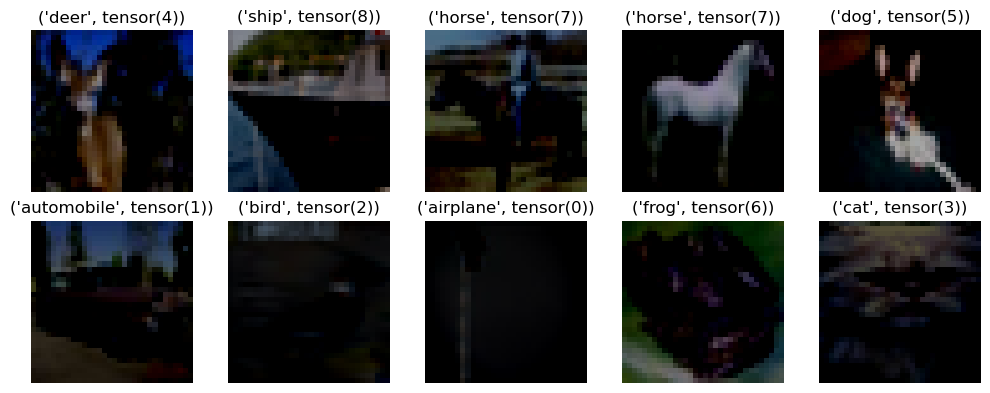

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class names
class_names = test_dataloader.dataset.classes
count = 0

# Create a subplot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the first batch of images and labels
for images, labels in test_dataloader:
    # Convert the images to numpy arrays
    images = images.numpy()
    
    # Iterate over the images and labels
    for i in range(len(images)):
        # Get the image and label
        image = images[i]
        label = labels[i]
        
        # Convert the image from tensor to numpy array
        image = np.transpose(image, (1, 2, 0))
        
        # Plot the image in the appropriate subplot
        ax = axs[count // 5, count % 5]
        ax.imshow(image)
        ax.set_title(f"{class_names[label], label}")
        ax.axis('off')
        
        # Increment the count
        count += 1
        
        # Break the loop if we have displayed 10 images
        if count == 10:
            break
            
    # Break the loop if we have displayed 10 images
    if count == 10:
        break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Imaplemant The Model

In [9]:
class Block(nn.Module):
    def __init__(self, inputs, outputs, _Downsample = False):
        super().__init__()
        self._Downsample = _Downsample

        
        self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        if self._Downsample == True:
            self.downsampling = nn.Sequential(
                # In paper, 
                # downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
                nn.Conv2d(inputs, outputs, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                # 이거 토치 공식 resnet에서도 배치까지 있는 4차원이라 conv2d로 함.
            )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m == self.conv1 and self._Downsample == True:
                    m.stride = (2, 2)
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # print('x1(identity) :', x.shape, 'Downsample :', self._Downsample)
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # print('x2 :', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self._Downsample == True:
            identity = self.downsampling(identity)
            # print('x1(downsampled) :', identity.shape)
        x = x + identity # 여기 x+=identity로 하면 안됨. inplace operation이라서.
        
        #x = self.relu2(x)
        # print('x3 :', x.shape)
        # print('x4 :', x.shape)
        return x
    
class MyResNet34(nn.Module):
    def __init__(self, _BlockClass = Block, _num_classes = 1000, _print = False):
        super().__init__()
        self._num_classes = _num_classes
        self._print = _print
        
        # 1. input layer
        # input : 224x224x3
        # output : 112x112x64
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # 2. 64ch 3x3 conv x 3
        # input : 112x112x64
        # output : 56x56x64
        self.conv64blocks = nn.Sequential(
            _BlockClass(64, 64),
            _BlockClass(64, 64),
            _BlockClass(64, 64)
        )
        # 3. 128ch 3x3 conv x 4
        # input : 56x56x64
        # output : 28x28x128
        self.conv128blocks = nn.Sequential(
            _BlockClass(64, 128, _Downsample = True),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
            _BlockClass(128, 128)
        )
        # 4. 256ch 3x3 conv x 6
        # input : 28x28x128
        # output : 14x14x256
        self.conv256blocks = nn.Sequential(
            _BlockClass(128, 256, _Downsample = True),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256)
        )
        # 5. 512ch 3x3 conv x 3
        # input : 14x14x256
        # output : 7x7x512
        self.conv512blocks = nn.Sequential(
            _BlockClass(256, 512, _Downsample = True),
            _BlockClass(512, 512),
            _BlockClass(512, 512)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features = 512, out_features= self._num_classes, bias=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        if(self._print): print('input 64ch :', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        if(self._print): print('conv7x7 64ch :', x.shape)
        x = self.maxpool(x)
        if(self._print): print('maxpool 64ch :', x.shape)
        
        x = self.conv64blocks(x)
        if(self._print): print('1st conv 64 :', x.shape)
        
        x = self.conv128blocks(x)
        if(self._print): print('2nd conv 128 :', x.shape)
        
        x = self.conv256blocks(x)
        if(self._print): print('3rd conv 256 :', x.shape)
        
        x = self.conv512blocks(x)
        if(self._print): print('4th conv 512:', x.shape)
        
        x = self.avgpool(x)
        if(self._print): print('avgpool :', x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = self.relu2(x)
        if(self._print): print('fc :', x.shape)
        
        return x

# Define the model

In [10]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [11]:
model = MyResNet34(Block, COUNT_OF_CLASSES, _print=False).to(device)
# model.named_modules

In [12]:
# How many have params?
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of total parameters: {total_params/1000/1000:2.2f}M")

Number of total parameters: 21.29M


In [13]:
# 모델 생성 및 손실 함수, 최적화기 정의
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop

In [14]:
NUM_EPOCHS = 20

_log_train_loss = []
_log_train_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # for inputs, labels in tqdm.tqdm(train_dataloader):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = correct / total

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")
    print("-" * 50)
    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)
    _log_test_loss.append(test_loss)
    _log_test_acc.append(test_acc)

Epoch 1/20:
Train Loss: 2.7925 | Train Acc: 25.43%
Test Loss: 1.7245 | Test Acc: 37.52%
Execution time: 25.95 seconds
--------------------------------------------------


KeyboardInterrupt: 

# Results

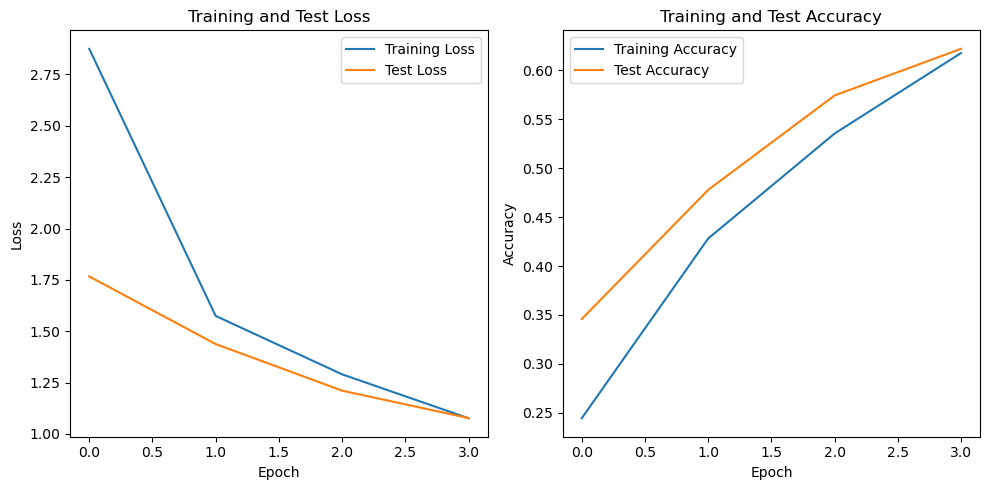

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(_log_train_loss, label="Training Loss")
axs[0].plot(_log_test_loss, label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(_log_train_acc, label="Training Accuracy")
axs[1].plot(_log_test_acc, label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "models/Myresnet34.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = MyResNet34(Block, COUNT_OF_CLASSES).to(device)
model.load_state_dict(torch.load("models/Myresnet34.pth"))

<All keys matched successfully>

In [ ]:
model.named_modules

<bound method Module.named_modules of MyResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv64blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU